# Base Classifier

by Michael Hunziker

## Summary
The aim of this notebook is to train a *Base Classifier* using TF-IDF and a standard ML classifier with default hyperparameters.

The aim of this notebook is to train a *Base Classifier* using TF-IDF and a standard ML classifier with default hyperparameters. This builds a *base line* upon which more advanced models (i.e. deep learning ones) should show better performance in order to be considered. Additionally, it also investigate the how much individual features (i.e. words) contribute to the class assignment (feature importance) in order to get an idea if the classifier makes *reasonable* decisions.

In a second step, this notebook uses hyperparameter tuning to automatically improve the performance of the Base Classifier.


*   Prepare Dataset
*   Build Pipeline
*   Evaluate
*   Use tweet tokenization
*   Hyperparameter Tuning


</br>

<a href="https://colab.research.google.com/github/miam-bonbon/assignment-adv-nlp/blob/main/adv_nlp_assignment_mh_03_baseline_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Let's do some imports

In [1]:
%%capture

!pip install 'fhnw-nlp-utils>=0.9.8,<0.10.0'

from fhnw.nlp.utils.storage import download
from fhnw.nlp.utils.storage import load_dataframe

import pandas as pd
import numpy as np

from fhnw.nlp.utils.system import set_log_level
from fhnw.nlp.utils.system import system_info

set_log_level()
print(system_info())

In [2]:
# create a DEV variable to use later
DEV = True

In [3]:
%%time

!rm "./data/COVIDSenti_tokenized_02.parq"

download("https://github.com/miam-bonbon/assignment-adv-nlp/raw/refs/heads/main/data/COVIDSenti_tokenized_02.parq", "data/COVIDSenti_tokenized_02.parq")
data = load_dataframe("data/COVIDSenti_tokenized_02.parq")
data.shape

rm: cannot remove './data/COVIDSenti_tokenized_02.parq': No such file or directory
CPU times: user 472 ms, sys: 112 ms, total: 584 ms
Wall time: 2.14 s


(22516, 8)

In [4]:
data.head(3)

,tweet,label,cleaned_tweet,lang,token_clean,token_no_stopwords_clean,text_clean,token_clean_tweet_tokenize
2,"TLDR: Not SARS, possibly new coronavirus. Diff...",neg,"TLDR: Not SARS, possibly new coronavirus. Diff...",en,"[tldr, :, sars, ,, possibly, new, coronavirus,...","[tldr, :, not, sars, ,, possibly, new, coronav...","tldr : sars , possibly new coronavirus . diffi...","[tldr, :, sars, ,, possibly, new, coronavirus,..."
8,@tezuma75 Why #CCP keep on saying unknown caus...,neg,Why #CCP keep on saying unknown cause of pneu...,en,"[#, ccp, keep, saying, unknown, cause, pneumon...","[why, #, ccp, keep, on, saying, unknown, cause...",# ccp keep saying unknown cause pneumonia ? ca...,"[#ccp, keep, saying, unknown, cause, pneumonia..."
11,I always feel weird hoping for another coronav...,neg,I always feel weird hoping for another coronav...,en,"[always, feel, weird, hoping, another, coronav...","[i, always, feel, weird, hoping, for, another,...",always feel weird hoping another coronavirus o...,"[always, feel, weird, hoping, another, coronav..."


We already removed neutral sentiments, since we classify binary.
We know we have a small dataset - let's give it a go to get experience.

In [5]:
val_counts = data["label"].value_counts().sort_index()
val_counts

,count
label,
neg,16273
pos,6243


We use stratification for the split (keep the ratio of the classes when splitting)

In [ ]:
from sklearn.model_selection import train_test_split

data_train, data_test = train_test_split(data, shuffle=True, random_state=43, stratify=data["label"])

X_train, y_train = data_train["text_clean"], data_train["label"]
X_test, y_test = data_test["text_clean"], data_test["label"]

# Now you have X_train, X_test, y_train, and y_test for your model training and evaluation
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(16887,) (5629,) (16887,) (5629,)


We need our stopwords back

In [ ]:
# %%capture

# if ('stopwords' not in locals()):
#   !pip install 'spacy>=3.0.5'
#   !pip install nltk
#   from nltk.corpus import stopwords
#   from nltk.stem.snowball import SnowballStemmer

#   import spacy
#   !python3 -m spacy download en_core_web_md

#   nlp = spacy.load("en_core_web_md")

#   import nltk
#   nltk.download('punkt')
#   nltk.download('stopwords')

#   stemmer = SnowballStemmer("english")
#   stopwords = set(stopwords.words("english"))
#   #stopwords = set(nlp.Defaults.stop_words)
#   empty_stopwords = set()

In [ ]:
%%time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

# we already preprocessed
pipe = Pipeline([
         ('vec', TfidfVectorizer()),
         ("clf", SGDClassifier(n_jobs=5))
        ])

pipe.fit(X_train, y_train)

CPU times: user 242 ms, sys: 0 ns, total: 242 ms
Wall time: 212 ms


Pipeline(steps=[('vec', TfidfVectorizer()), ('clf', SGDClassifier(n_jobs=5))])

In [ ]:
%%time

y_train_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)

CPU times: user 327 ms, sys: 1.44 ms, total: 328 ms
Wall time: 428 ms


Let's get the classification report

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_train, y_train_pred)
print("Train:")
print(report)
report = classification_report(y_test, y_test_pred)
print("Test:")
print(report)

Train:
              precision    recall  f1-score   support

         neg       0.96      0.99      0.97     12205
         pos       0.97      0.89      0.93      4682

    accuracy                           0.96     16887
   macro avg       0.96      0.94      0.95     16887
weighted avg       0.96      0.96      0.96     16887

Test:
              precision    recall  f1-score   support

         neg       0.93      0.98      0.95      4068
         pos       0.94      0.81      0.87      1561

    accuracy                           0.93      5629
   macro avg       0.93      0.89      0.91      5629
weighted avg       0.93      0.93      0.93      5629



And the confusion matrix

Set Population: 16887
Accuracy: 0.9603


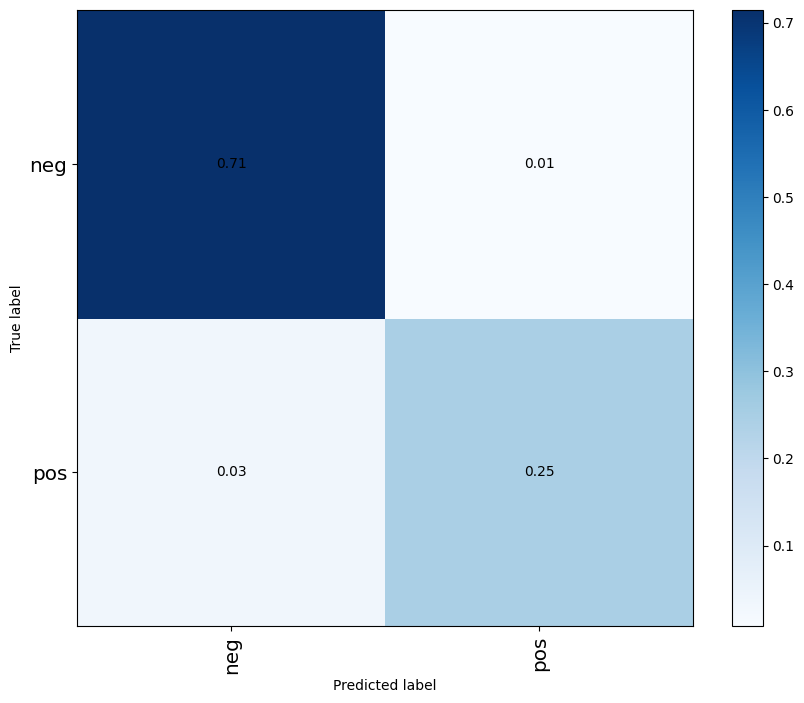

Set Population: 5629
Accuracy: 0.9311


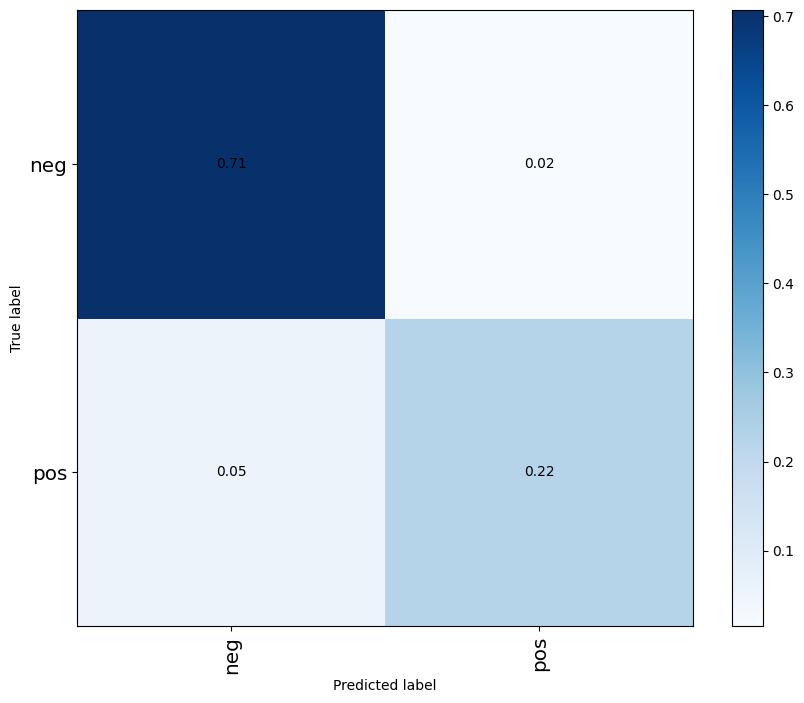

In [ ]:
from fhnw.nlp.utils.ploting import plot_confusion_matrix

plot_confusion_matrix(y_train.tolist(), y_train_pred)
plot_confusion_matrix(y_test.tolist(), y_test_pred)

Feature importance in order to get an idea if the class assignment builds on reasonable words

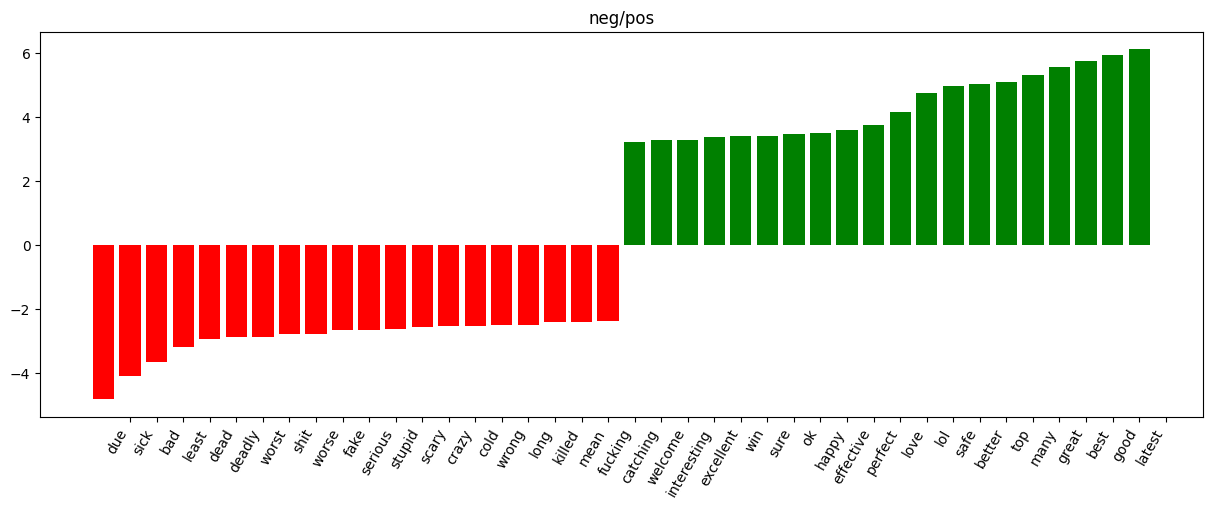

In [ ]:
from fhnw.nlp.utils.ploting import plot_feature_importance

vectorizer = pipe.named_steps["vec"]
# only works since SGDClassifier uses LinearSVC by default
classifier = pipe.named_steps["clf"]

plot_feature_importance(classifier, vectorizer.get_feature_names_out())

This looks good! Let's get an impression on texts with wrong prediction

In [ ]:
pd.set_option('display.max_colwidth', None)

data_train["prediction"] = y_train_pred

data_train[data_train["label"] != data_train["prediction"]][["text_clean", "label", "prediction"]]

,text_clean,label,prediction
77592,"breaking # foxnews alert : dow falls , points , suffering worst-ever one-day drop , oil prices crash coronavirus spreads",pos,neg
39263,trump knows corona virus anyone else ... ask .,pos,neg
8547,"wuhan coronavirus : , tourists lockdown cruise ship italy # health #",pos,neg
76984,"oh , thats good . # covid # coronavirus",neg,pos
21217,oh ! think corona virus ? ? ? praying ! ! ! ! im sure,neg,pos
...,...,...,...
62360,good thing coronavirus make seem less terrifying,neg,pos
22882,# viral news : misinformation coronavirus causing infodemic,pos,neg
55474,"iran temporarily release , prisoners attempt prevent spread coronavirus . mo",pos,neg
10529,always types corona virus novel virus nothing weve experienced,pos,neg


Theese seem better than the label!

# Using the Tweet Tokenized Tokens

Let's try how our tweet tokenized version fares

In [23]:
data.head(25)

,tweet,label,cleaned_tweet,lang,token_clean,token_no_stopwords_clean,text_clean,token_clean_tweet_tokenize
2,"TLDR: Not SARS, possibly new coronavirus. Diff...",neg,"TLDR: Not SARS, possibly new coronavirus. Diff...",en,"[tldr, :, sars, ,, possibly, new, coronavirus,...","[tldr, :, not, sars, ,, possibly, new, coronav...","tldr : sars , possibly new coronavirus . diffi...","[tldr, :, sars, ,, possibly, new, coronavirus,..."
8,@tezuma75 Why #CCP keep on saying unknown caus...,neg,Why #CCP keep on saying unknown cause of pneu...,en,"[#, ccp, keep, saying, unknown, cause, pneumon...","[why, #, ccp, keep, on, saying, unknown, cause...",# ccp keep saying unknown cause pneumonia ? ca...,"[#ccp, keep, saying, unknown, cause, pneumonia..."
11,I always feel weird hoping for another coronav...,neg,I always feel weird hoping for another coronav...,en,"[always, feel, weird, hoping, another, coronav...","[i, always, feel, weird, hoping, for, another,...",always feel weird hoping another coronavirus o...,"[always, feel, weird, hoping, another, coronav..."
16,@KariDebbink @Vineet321 The Frieman Scary Scal...,neg,The Frieman Scary Scale makes its debut. Wuh...,en,"[frieman, scary, scale, makes, debut, ., wuhan...","[the, frieman, scary, scale, makes, its, debut...",frieman scary scale makes debut . wuhan corona...,"[frieman, scary, scale, makes, debut, ., wuhan..."
18,"Crap, a quick blast search suggests the Wuhan ...",neg,"Crap, a quick blast search suggests the Wuhan ...",en,"[crap, ,, quick, blast, search, suggests, wuha...","[crap, ,, a, quick, blast, search, suggests, t...","crap , quick blast search suggests wuhan coron...","[crap, ,, quick, blast, search, suggests, wuha..."
24,China releases genetic data on new coronavirus...,neg,China releases genetic data on new coronavirus...,en,"[china, releases, genetic, data, new, coronavi...","[china, releases, genetic, data, on, new, coro...","china releases genetic data new coronavirus , ...","[china, releases, genetic, data, new, coronavi..."
31,"Brace yourself #America, this virus is nasty &...",neg,"Brace yourself #America, this virus is nasty &...",en,"[brace, #, america, ,, virus, nasty, &, killer...","[brace, yourself, #, america, ,, this, virus, ...","brace # america , virus nasty & killer . # # c...","[brace, #america, ,, virus, nasty, &, killer, ..."
49,Wtf is #coronavirus,neg,Wtf is #coronavirus,en,"[wtf, #, coronavirus]","[wtf, is, #, coronavirus]",wtf # coronavirus,"[wtf, #coronavirus]"
55,„ÇΩ„Éº„Çπ\nChina coronavirus: at least three s...,neg,China coronavirus: at least three suspected c...,en,"[china, coronavirus, :, least, three, suspecte...","[china, coronavirus, :, at, least, three, susp...",china coronavirus : least three suspected case...,"[china, coronavirus, :, least, three, suspecte..."
61,YVR on alert for deadly coronavirus spreading ...,neg,YVR on alert for deadly coronavirus spreading ...,en,"[yvr, alert, deadly, coronavirus, spreading, c...","[yvr, on, alert, for, deadly, coronavirus, spr...",yvr alert deadly coronavirus spreading china,"[yvr, alert, deadly, coronavirus, spreading, c..."


In [24]:
from sklearn.model_selection import train_test_split

data_train, data_test = train_test_split(data, shuffle=True, random_state=43, stratify=data["label"])

X_train, y_train = data_train["token_clean_tweet_tokenize"], data_train["label"]
X_test, y_test = data_test["token_clean_tweet_tokenize"], data_test["label"]

# Now you have X_train, X_test, y_train, and y_test for your model training and evaluation
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(X_train.head(3))

(16887,) (5629,) (16887,) (5629,)
50978    [p, ., damn, coronavirus, outbreak, making, im...
55745    [yeah, coronavirus, real, scary, serious, ive,...
43043    [chinese, scientists, desperately, researching...
Name: token_clean_tweet_tokenize, dtype: object


In [27]:
# prompt: show all rows from x_train where a "#" is present in "token_clean_tweet_tokenize", remember column "token_clean_tweet_tokenize" is an array

import pandas as pd

# Assuming 'data_train' DataFrame is already loaded as in your provided code.
# If not, load it first using the appropriate code.

# Convert the 'token_clean_tweet_tokenize' column to strings
data_train['token_clean_tweet_tokenize'] = data_train['token_clean_tweet_tokenize'].astype(str)

# Filter rows where the 'token_clean_tweet_tokenize' column contains '#'
rows_with_hash = data_train[data_train['token_clean_tweet_tokenize'].str.contains('#')]

# Print or process the filtered rows
rows_with_hash

,tweet,label,cleaned_tweet,lang,token_clean,token_no_stopwords_clean,text_clean,token_clean_tweet_tokenize
77592,Breaking #FoxNews Alert : Dow falls more than ...,pos,Breaking #FoxNews Alert : Dow falls more than ...,en,"[breaking, #, foxnews, alert, :, dow, falls, ,...","[breaking, #, foxnews, alert, :, dow, falls, m...","breaking # foxnews alert : dow falls , points ...",['breaking' '#foxnews' 'alert' ':' 'dow' 'fall...
21346,@thecaravanindia The pathetic response of #HKG...,neg,The pathetic response of #HKGov towards #Wuha...,en,"[pathetic, response, #, hkgov, towards, #, wuh...","[the, pathetic, response, of, #, hkgov, toward...",pathetic response # hkgov towards # wuhanvirus...,['pathetic' 'response' '#hkgov' 'towards' '#wu...
71151,This email from my gym about #coronavirus is m...,neg,This email from my gym about #coronavirus is m...,en,"[email, gym, #, coronavirus, maybe, least, rea...","[this, email, from, my, gym, about, #, coronav...",email gym # coronavirus maybe least reassuring...,['email' 'gym' '#coronavirus' 'maybe' 'least' ...
14453,The government requested the public to refrain...,neg,The government requested the public to refrain...,en,"[government, requested, public, refrain, creat...","[the, government, requested, the, public, to, ...",government requested public refrain creating u...,['government' 'requested' 'public' 'refrain' '...
34172,"Today's show LIVE 9amEST\nüëâ#DemDebate, the ...",neg,"Today's show LIVE amEST #DemDebate, the losers...",en,"[today, 's, show, live, amest, #, demdebate, ,...","[today, 's, show, live, amest, #, demdebate, ,...","today 's show live amest # demdebate , losers ...","[""today's"" 'show' 'live' 'amest' '#demdebate' ..."
...,...,...,...,...,...,...,...,...
31913,Some more #goodnews on #COVID„Éº19 -progress o...,pos,Some more #goodnews on #COVID -progress on dru...,en,"[#, goodnews, #, covid, -progress, drugs, trea...","[some, more, #, goodnews, on, #, covid, -progr...",# goodnews # covid -progress drugs treat # cor...,['#goodnews' '#covid' '-' 'progress' 'drugs' '...
3886,#CoronaOutbreak #coronavirus #health #Mauritiu...,pos,#CoronaOutbreak #coronavirus #health #Mauritiu...,en,"[#, coronaoutbreak, #, coronavirus, #, health,...","[#, coronaoutbreak, #, coronavirus, #, health,...",# coronaoutbreak # coronavirus # health # maur...,['#coronaoutbreak' '#coronavirus' '#health' '#...
3959,Chinese provincial press conference on coronav...,neg,Chinese provincial press conference on coronav...,en,"[chinese, provincial, press, conference, coron...","[chinese, provincial, press, conference, on, c...",chinese provincial press conference coronaviru...,['chinese' 'provincial' 'press' 'conference' '...
27664,"Okay, here's Project Avalon's Bill Ryan with n...",pos,"Okay, here's Project Avalon's Bill Ryan with n...",en,"[okay, ,, 's, project, avalon, 's, bill, ryan,...","[okay, ,, here, 's, project, avalon, 's, bill,...","okay , 's project avalon 's bill ryan news # c...","['okay' ',' ""here's"" 'project' ""avalon's"" 'bil..."


In [6]:
%%time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

from fhnw.nlp.utils.processing import identity

# we use the tokens now
pipe = Pipeline([
         ("vec", TfidfVectorizer(tokenizer=identity, preprocessor=identity, stop_words=None)),
         ("clf", SGDClassifier(n_jobs=5))
        ])

pipe.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CPU times: user 332 ms, sys: 11.7 ms, total: 343 ms
Wall time: 378 ms


Pipeline(steps=[('vec',
                 TfidfVectorizer(preprocessor=<function identity at 0x7a1d089239a0>,
                                 tokenizer=<function identity at 0x7a1d089239a0>)),
                ('clf', SGDClassifier(n_jobs=5))])

In [7]:
%%time

y_train_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)

CPU times: user 158 ms, sys: 103 µs, total: 158 ms
Wall time: 160 ms


In [8]:
from sklearn.metrics import classification_report

report = classification_report(y_train, y_train_pred)
print("Train:")
print(report)
report = classification_report(y_test, y_test_pred)
print("Test:")
print(report)

Train:
              precision    recall  f1-score   support

         neg       0.95      0.99      0.97     12205
         pos       0.97      0.88      0.92      4682

    accuracy                           0.96     16887
   macro avg       0.96      0.93      0.95     16887
weighted avg       0.96      0.96      0.96     16887

Test:
              precision    recall  f1-score   support

         neg       0.93      0.98      0.95      4068
         pos       0.94      0.81      0.87      1561

    accuracy                           0.93      5629
   macro avg       0.93      0.89      0.91      5629
weighted avg       0.93      0.93      0.93      5629



Set Population: 16887
Accuracy: 0.9559


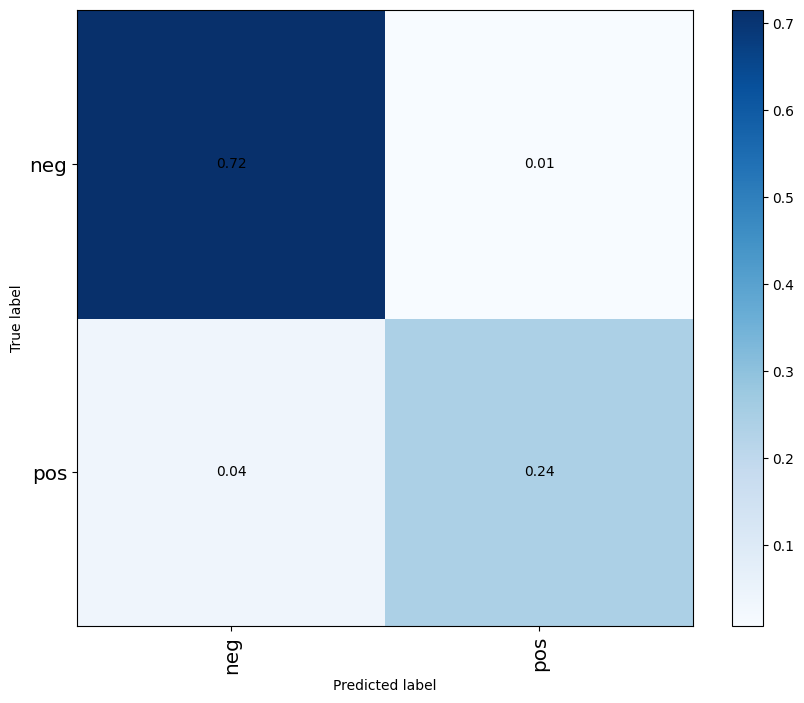

Set Population: 5629
Accuracy: 0.9295


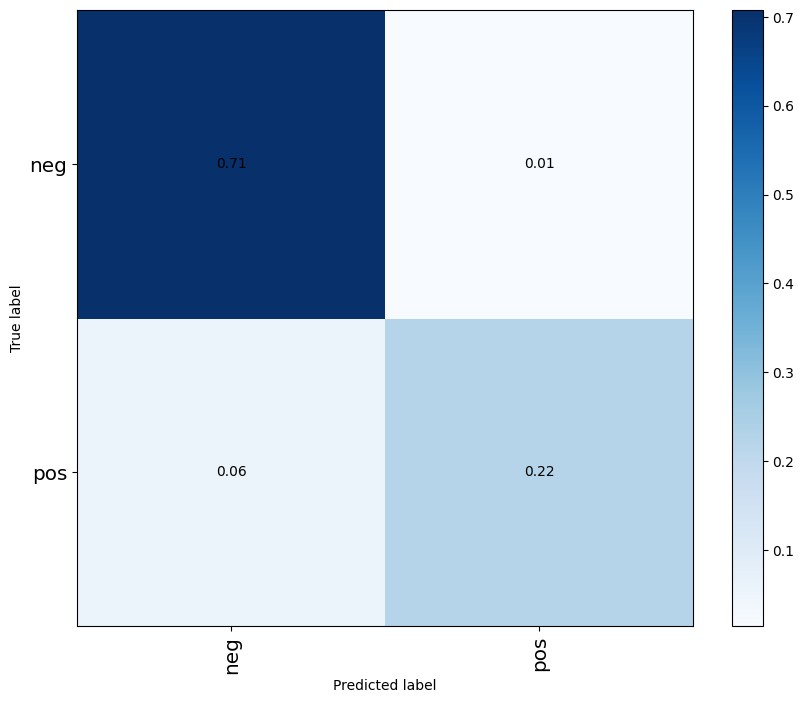

In [14]:
from fhnw.nlp.utils.ploting import plot_confusion_matrix

plot_confusion_matrix(y_train.tolist(), y_train_pred)
plot_confusion_matrix(y_test.tolist(), y_test_pred)

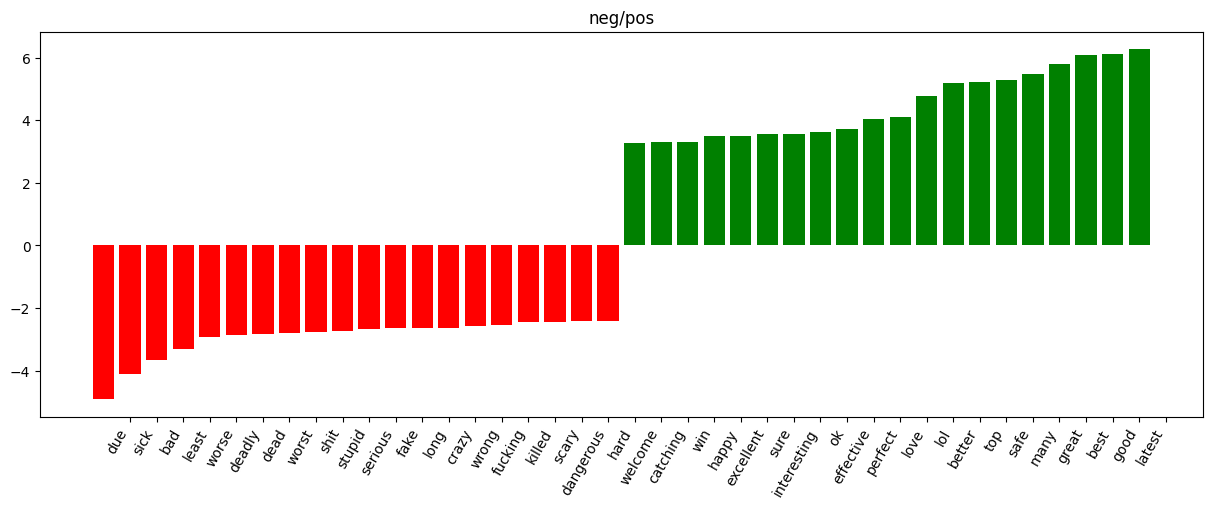

In [30]:
from fhnw.nlp.utils.ploting import plot_feature_importance

vectorizer = pipe.named_steps["vec"]
# only works since SGDClassifier uses LinearSVC by default
classifier = pipe.named_steps["clf"]

plot_feature_importance(classifier, vectorizer.get_feature_names_out())

Let's see how our hashtags fare

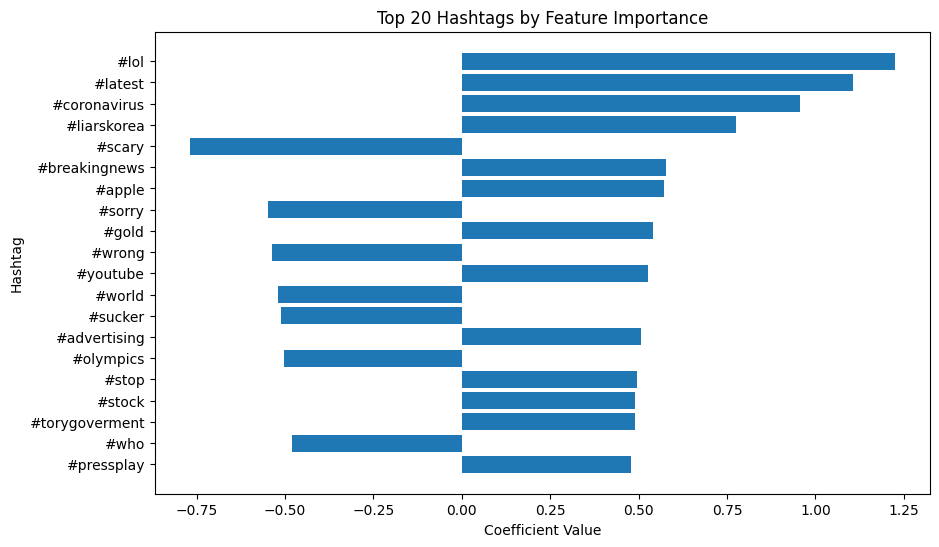

In [31]:
import matplotlib.pyplot as plt

# Assuming 'classifier' and 'vectorizer' are already defined as in your code.
feature_names = vectorizer.get_feature_names_out()
# Extract coefficients from the classifier
coefficients = classifier.coef_[0]

# Filter for hashtags
hashtag_indices = [i for i, name in enumerate(feature_names) if name.startswith("#")]
hashtag_names = [feature_names[i] for i in hashtag_indices]
hashtag_coefficients = [coefficients[i] for i in hashtag_indices]

# Sort hashtags by absolute coefficient magnitude
hashtag_importance = sorted(zip(hashtag_names, hashtag_coefficients), key=lambda x: abs(x[1]), reverse=True)


# Plotting the top N hashtags
N = 20 # change this value to display a different number of top features

# Create the plot
plt.figure(figsize=(10, 6))
plt.barh(range(N), [importance[1] for importance in hashtag_importance[:N]], align='center')
plt.yticks(range(N), [importance[0] for importance in hashtag_importance[:N]])
plt.xlabel('Coefficient Value')
plt.ylabel('Hashtag')
plt.title(f'Top {N} Hashtags by Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to display highest importance at the top
plt.show()

They are not compounded enough to play a role

In [16]:
pd.set_option('display.max_colwidth', None)

data_train["prediction"] = y_train_pred

data_train[data_train["label"] != data_train["prediction"]][["text_clean", "label", "prediction"]]

,text_clean,label,prediction
77592,"breaking # foxnews alert : dow falls , points , suffering worst-ever one-day drop , oil prices crash coronavirus spreads",pos,neg
39263,trump knows corona virus anyone else ... ask .,pos,neg
8547,"wuhan coronavirus : , tourists lockdown cruise ship italy # health #",pos,neg
76984,"oh , thats good . # covid # coronavirus",neg,pos
21217,oh ! think corona virus ? ? ? praying ! ! ! ! im sure,neg,pos
...,...,...,...
22882,# viral news : misinformation coronavirus causing infodemic,pos,neg
55474,"iran temporarily release , prisoners attempt prevent spread coronavirus . mo",pos,neg
10529,always types corona virus novel virus nothing weve experienced,pos,neg
30375,giveaway ! type ! enter accepting embers donations # mixer # love # coronavirus # redbull # tradecentre,pos,neg


# Hyperparameter Tuning

Let's further try improving the results by using optima hypertuning.

We already tokenized during the preprocessing stage. We will compare the word tokenized tokens to the tweet optimized ones!

In [ ]:
# %%capture

# !pip uninstall optuna -y

In [ ]:
%%capture

!pip install optuna

In [ ]:
import optuna

print(optuna.__version__)

4.1.0


Can we use the same pipline?

As we have an imbalanced dataset and want to give equal importance to each class, we compare the binary to the macro average and expect better results from the latter.

In [ ]:
from sklearn.metrics import f1_score, make_scorer

scoring_function = make_scorer(f1_score, pos_label="positive", average='binary')
#scoring_function = make_scorer(f1_score, average='macro')

We define the parameters for optima:

vec__max_df: This parameter is for the TfidfVectorizer, the component that converts text into numerical features.
max_df determines the maximum document frequency for a term to be included in the vocabulary.</br>
Our setting tells Optuna to try different values for max_df between 0.5 and 0.85 (inclusive). This means words appearing in more than 85% of the documents will be ignored.

"vec__min_df": Also for the TfidfVectorizer.
min_df sets the minimum document frequency for a term.</br>
Our setting instructs Optuna to sample values between 0.0 and 0.2. This means words appearing in less than 20% of the documents will be ignored.

vec__ngram_range: (Commented out in this case, meaning it's not being tuned).
This would control whether the TfidfVectorizer considers single words (1, 1), word pairs (1, 2), or word triplets (1, 3) as features.</br>
Our setting would allow Optuna to choose from the provided options.

"vec__use_idf": For the TfidfVectorizer.
use_idf determines whether to use Inverse Document Frequency (IDF) weighting. IDF downweights words that appear frequently across all documents, making them less important for distinguishing between documents.</br>
Our setting tells Optuna to test both using IDF (True) and not using it (False).

"vec__sublinear_tf": For the TfidfVectorizer.
sublinear_tf applies a sublinear scaling to term frequencies. If True, it uses 1 + log(tf) instead of just tf to reduce the impact of very frequent terms.</br>
Our setting instructs Optuna to evaluate both options (True and False).

"vec__max_features": (Commented out)
This would limit the maximum number of features (words) to be considered by the TfidfVectorizer.</br>
Our setting would have Optuna try values between 1000 and 100,000.

"clf__alpha": This hyperparameter is for the SGDClassifier, the machine learning model used for classification.
alpha is a regularization parameter that controls the strength of the penalty imposed on the model's weights. Higher values of alpha lead to stronger regularization, which can help prevent overfitting.</br>
Our setting tells Optuna to explore values between 1e-7 and 1e-4 on a logarithmic scale.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

def objective(trial):

    # TODO: !!! place your code here !!!
    ####################################
    #params = {
    #    "clf__alpha": trial.suggest_...,
    #    ...
    #}

    params = {
        "vec__max_df": trial.suggest_float("vec__max_df", 0.5, 0.85),
        "vec__min_df": trial.suggest_float("vec__min_df", 0.0, 0.2),
        #"vec__ngram_range": trial.suggest_categorical("vec__ngram_range", [(1, 1), (1, 2), (1, 3)]),
        "vec__use_idf": trial.suggest_categorical("vec__use_idf", [True, False]),
        "vec__sublinear_tf": trial.suggest_categorical("vec__sublinear_tf", [True, False]),
        #"vec__max_features": trial.suggest_int("vec__max_features", 1000, 100_000) ,
        "clf__alpha": trial.suggest_float("clf__alpha",1e-7, 1e-4, log=True),
    }

    ###################
    # TODO: !!! end !!!

    # set the hyper parameters to try
    pipe.set_params(**params)

    return np.mean(cross_val_score(
        pipe,
        X_train,
        y_train,
        # Stratified K-Folds cross-validator (with 3 splits/folds)
        cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
        n_jobs=-1,
        scoring=scoring_function))